In [57]:
import ROOT
import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt

ROOT.gROOT.ProcessLine( "gErrorIgnoreLevel = kError;");

In [58]:
def convert_to_double(df, col):
    df[col] =  df[col].apply(lambda s: np.float64(s))

In [59]:
def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

# Benchmarks
Plot benchmark results from running histond_benchmark.C with timers within TH1

## No Bulk API

### Fixed Bins

In [60]:
filename = "nonbulk_1d_fixedbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_double(df_bm, "tfindbin")
convert_to_double(df_bm, "tfill")
convert_to_double(df_bm, "tstats")
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,1.937491,1.620788,1.555348,1.000000e+08,uniform
1,0,CPU,1,1,9.478474,7.850704,7.620397,5.000000e+08,uniform
2,0,CPU,1,1,19.088344,15.712114,15.305721,1.000000e+09,uniform
3,0,CPU,1,1,94.319963,87.005841,75.569822,5.000000e+09,uniform
4,0,CPU,2,1,1.883125,1.552552,1.507859,1.000000e+08,uniform
5,0,CPU,2,1,9.347063,7.682685,7.485839,5.000000e+08,uniform
6,0,CPU,2,1,18.750533,15.447757,15.021956,1.000000e+09,uniform


In [61]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter   tfindbin      tfill  \
env distribution nvals        nbins bulksize                               
CPU uniform      1.000000e+08 1     1          1.0   1.875294   1.551172   
                              2     1          1.0   1.862105   1.540116   
                              5     1          1.0   1.876629   1.579942   
                              10    1          1.0   1.867486   1.538372   
                              20    1          1.0   1.861202   1.534309   
                              50    1          1.0   1.826746   1.556542   
                              100   1          1.0   1.822405   1.498089   
                              500   1          1.0   1.827565   1.562940   
                              1000  1          1.0   1.850249   1.542947   
                 5.000000e+08 1     1          1.0   9.333347   7.917787   
                              2     1          1.0   9.248723   7.584963   
                              5     1          1.0   9.256350   7.631018   
                              10    1          1.0   9.256568   7.609552   
                              20    1          1.0   9.342807   7.892647   
                              50    1          1.0   9.261069   8.100508   
                              100   1          1.0   9.203016   7.481004   
                              500   1          1.0   9.147344   7.538352   
                              1000  1          1.0   9.227314   8.092365   
                 1.000000e+09 1     1          1.0  18.951855  15.468729   
                              2     1          1.0  18.545456  15.268573   
                              5     1          1.0  18.611900  15.309308   
                              10    1          1.0  18.657480  15.357767   
                              20    1          1.0  18.797937  15.647771   
                              50    1          1.0  18.441803  16.397713   
                              100   1          1.0  18.210651  15.044283   
                              500   1          1.0  18.319942  15.118158   
                              1000  1          1.0  18.474962  15.552236   
                 5.000000e+09 1     1          1.0  92.750470  86.291794   
                              2     1          1.0  92.807932  79.815401   
                              5     1          1.0  93.170286  77.519193   
                              10    1          1.0  95.189293  76.317781   
                              20    1          1.0  92.653465  76.921896   
                              50    1          1.0  91.370868  75.648633   
                              100   1          1.0  91.926550  77.635879   
                              500   1          1.0  91.307255  75.821473   
                              1000  1          1.0  91.581583  77.306689   

                                                 tstats  
env distribution nvals        nbins bulksize             
CPU uniform      1.000000e+08 1     1          1.503002  
                              2     1          1.492257  
                              5     1          1.496295  
                              10    1          1.496536  
                              20    1          1.490506  
                              50    1          1.463339  
                              100   1          1.458444  
                              500   1          1.464790  
                              1000  1          1.513280  
                 5.000000e+08 1     1          7.487946  
                              2     1          7.378729  
                              5     1          7.412561  
                              10    1          7.409907  
                              20    1          7.414596  
                              50    1          7.324639  
                              100   1          7.267518  
                              500   1          7.319509  
                              1000  1          7.520136

In [62]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
# unique_nvals = [500000000]
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([1.e+08, 5.e+08, 1.e+09, 5.e+09]),
 array([1.]))

Plots the total time spent on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

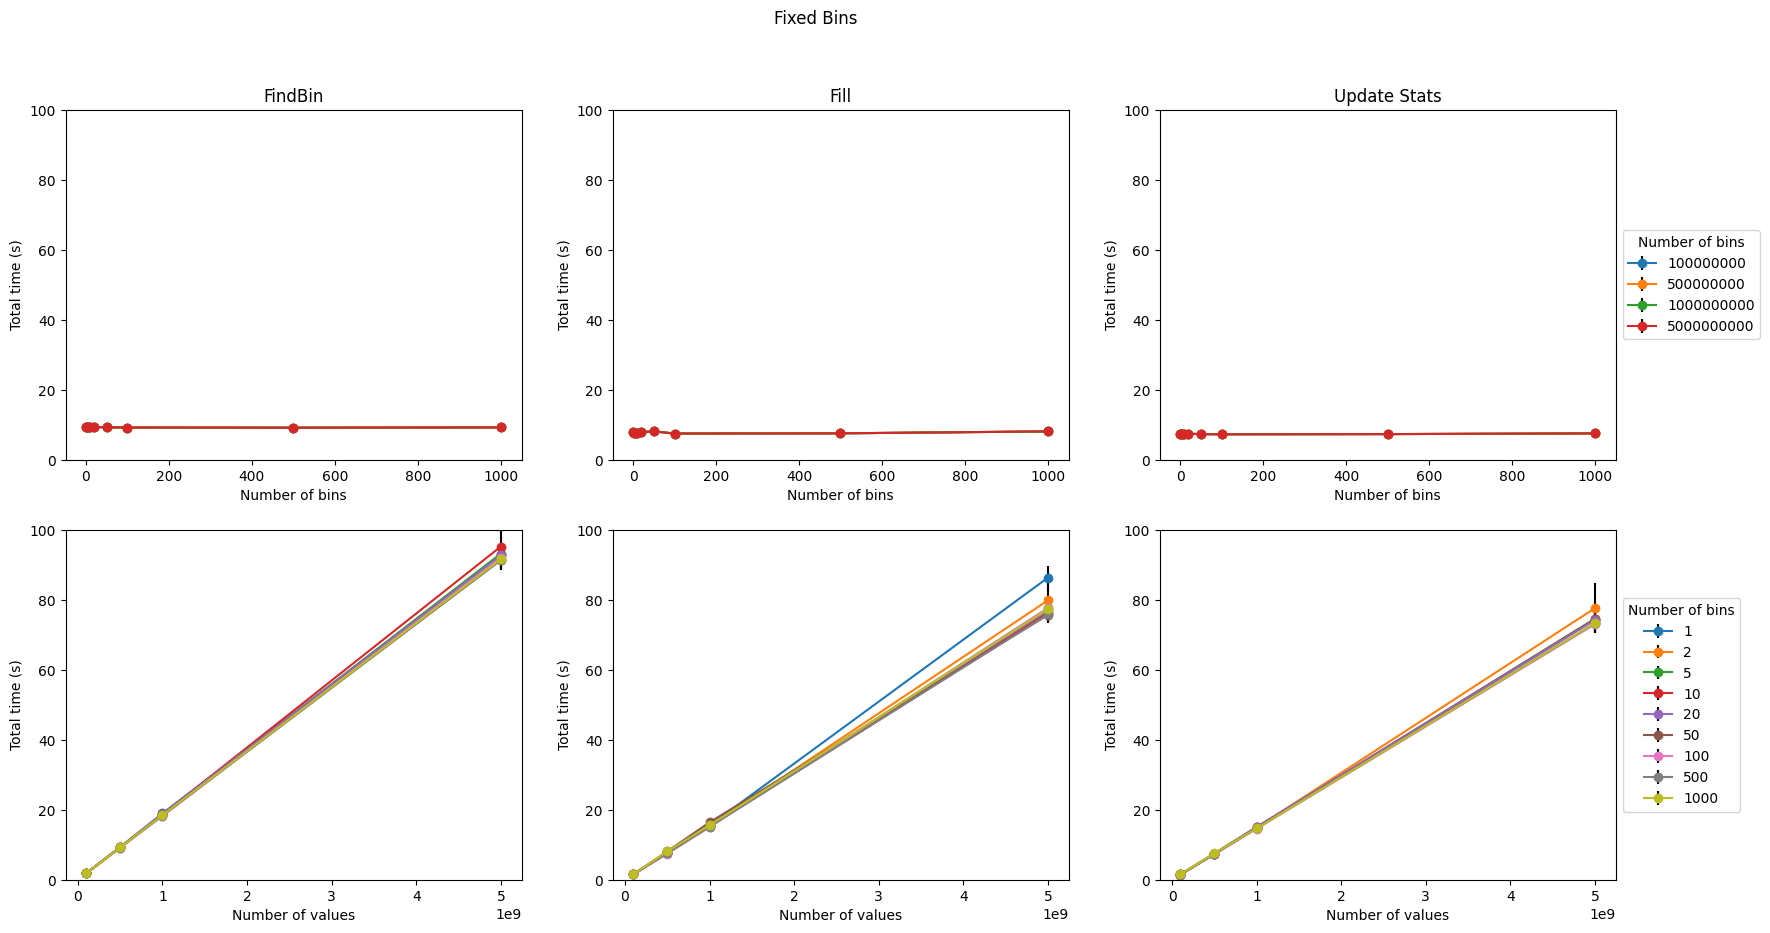

In [63]:
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins")

def plot_perval(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(unique_nbins, gp_bm.mean().loc["CPU", "uniform", 500000000, :, 1][col], yerr=gp_bm.std().loc["CPU", "uniform", 500000000, :, 1][col], marker="o", ecolor="k", label=f"{int(nv)}")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_nvals, gp_bm.mean().loc["CPU", "uniform", :, nb, 1][col], yerr=gp_bm.std().loc["CPU", "uniform", :, nb, 1][col], marker="o", ecolor="k", label=f"{int(nb)}")
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel(ylabel)

ylim=[0,100]
plt.subplot(231)
plot_perval("FindBin", "tfindbin", "Number of bins",  "Total time (s)", ylim)

plt.subplot(232)
plot_perval("Fill", "tfill", "Number of bins",  "Total time (s)", ylim)

plt.subplot(233)
plot_perval("Update Stats", "tstats", "Number of bins",  "Total time (s)", ylim)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

ylim = [0, 100]
plt.subplot(234)
plot_perbin("", "tfindbin", "Number of values",  "Total time (s)", ylim)

plt.subplot(235)
plot_perbin("", "tfill", "Number of values",  "Total time (s)", ylim)

plt.subplot(236)
plot_perbin("", "tstats", "Number of values",  "Total time (s)", ylim)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

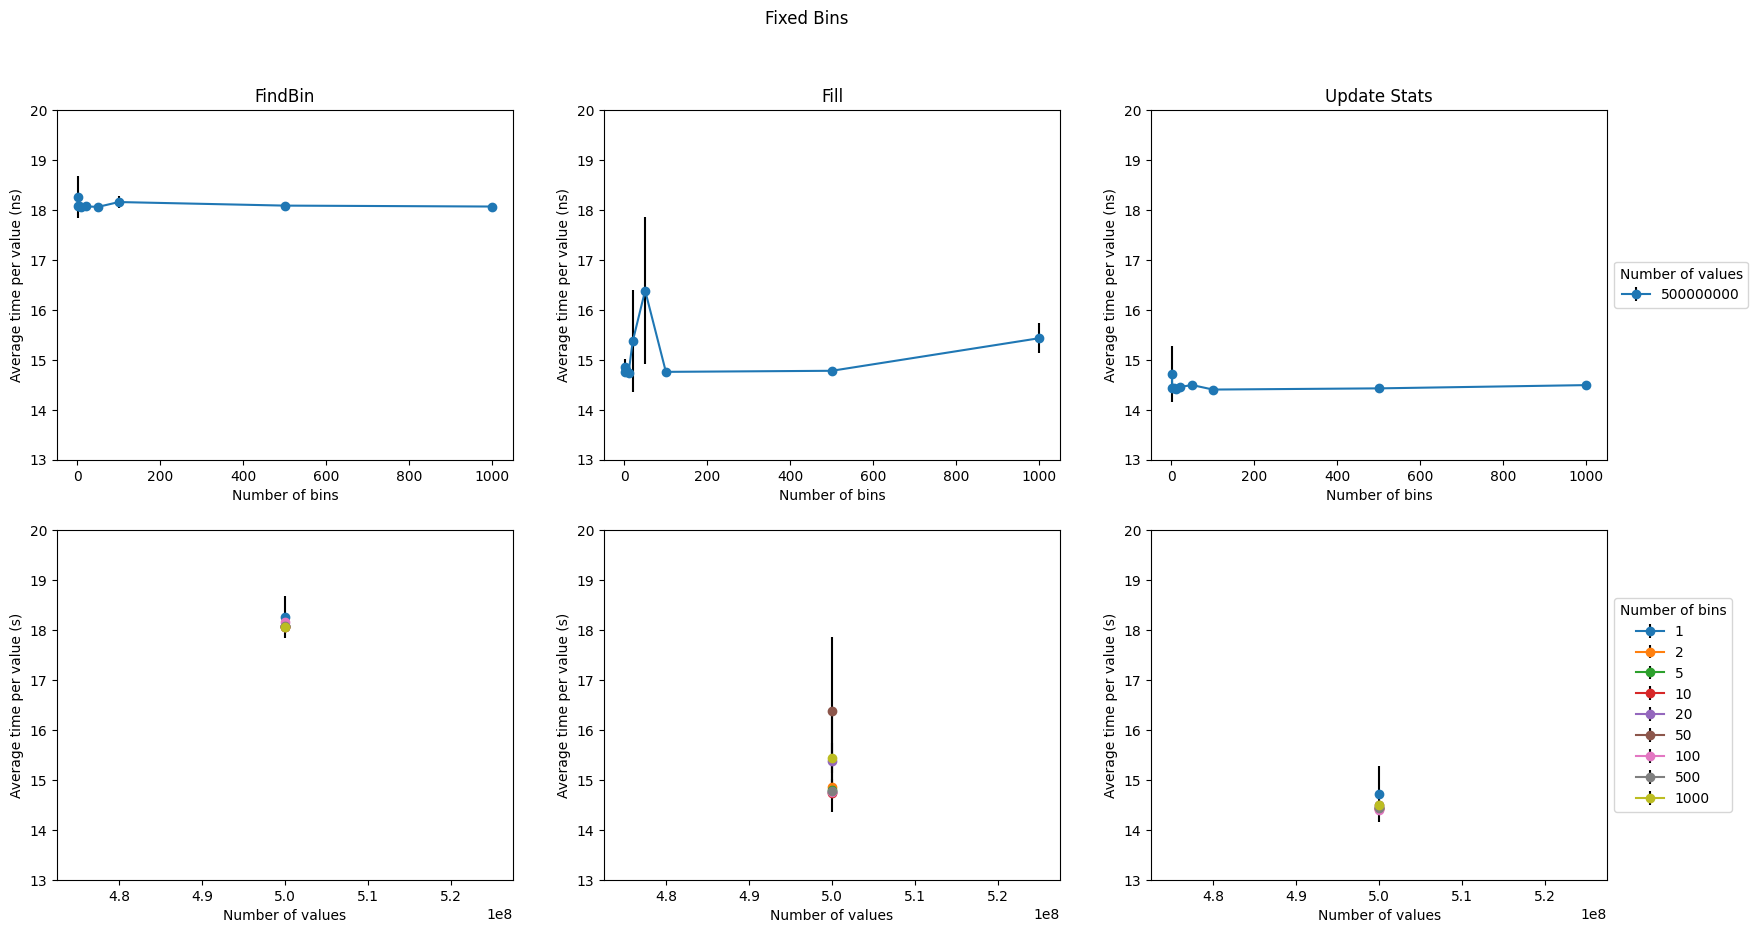

In [89]:
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins")

def plot_perval_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(unique_nbins, gp_bm.mean().loc["CPU", "uniform", nv, :, 1][col]/nv/norm, yerr=gp_bm.std().loc["CPU", "uniform", nv, :, 1][col]/nv/norm, marker="o", ecolor="k", label=f"{int(nv)}")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_nvals, gp_bm.mean().loc["CPU", "uniform", :, nb, 1][col]/unique_nvals/norm, yerr=gp_bm.std().loc["CPU", "uniform", :, nb, 1][col]/unique_nvals/norm, marker="o", ecolor="k", label=f"{int(nb)}")
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel("Average time per value (s)")

norm = 1e-9
ylim = [13, 20]
plt.subplot(231)
plot_perval_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(232)
plot_perval_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(233)
plot_perval_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

ylim = [13, 20]
plt.subplot(234)
plot_perbin_normalized("", "tfindbin", "Number of values",  "Average time per value (ns)", ylim, norm)

plt.subplot(235)
plot_perbin_normalized("", "tfill", "Number of values",  "Average time per value (ns)", ylim, norm)

plt.subplot(236)
plot_perbin_normalized("", "tstats", "Number of values",  "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

#### root plot

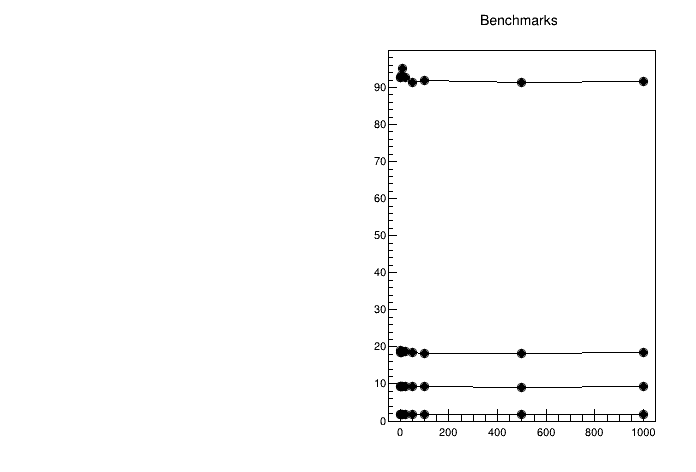

In [65]:
def setAxes(g, xtitle="", ytitle=""):
    xaxis = g.GetXaxis()
    xaxis.SetTitle(xtitle)
    # xaxis.SetTitleOffset(3)
    xaxis.SetTitleSize(0.05)
    xaxis.SetTickSize(0)
    xaxis.SetLabelSize(0.05)
    xaxis.LabelsOption("vM")
    xaxis.SetRangeUser(0, 200)
    
    yaxis = g.GetYaxis()
    yaxis.SetTitle(ytitle)
    yaxis.SetTitleSize(0.05)
    yaxis.SetLabelSize(0.05)
    yaxis.SetRangeUser(0, 40)
    
w = 1600
h = 900
c = ROOT.TCanvas("c1", "")
# c.SetRightMargin(0.36)
# c.SetBottomMargin(0.33)
c.Divide(2,1)
l = ROOT.TLegend(0.65, 0.7, 0.92, 0.9)
l.SetTextSize(0.05)

title="Benchmarks"
c.cd(1)
mg = ROOT.TMultiGraph("mg", title)
for nv in unique_nvals:
    # g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, gp_bm.mean().loc["CPU", "uniform", nv, :, 1]["tfindbin"].values, ROOT.nullptr, gp_bm.std().loc["CPU", "uniform", nv, :, 1]["tfindbin"].values)
    g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, gp_bm.mean().loc["CPU", "uniform", nv, :, 1]["tfindbin"].values)
    g.SetMarkerSize(1)
    g.SetMarkerStyle(20)
    mg.Add(g, "PL")
    l.AddEntry(g, str(nv), "p")
mg.Draw("A")

c.cd(2)
mg = ROOT.TMultiGraph("mg", title)
for nv in unique_nvals:
    # g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, gp_bm.mean().loc["CPU", "uniform", nv, :, 1]["tfindbin"].values, ROOT.nullptr, gp_bm.std().loc["CPU", "uniform", nv, :, 1]["tfindbin"].values)
    g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, gp_bm.mean().loc["CPU", "uniform", nv, :, 1]["tfindbin"].values)
    g.SetMarkerSize(1)
    g.SetMarkerStyle(20)
    mg.Add(g, "PL")
    l.AddEntry(g, str(nv), "p")
mg.Draw("A")

# l.Draw()
c.cd()
c.Draw()

### Variable Bins

In [66]:
filename = "nonbulk_1d_varbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_double(df_bm, "tfindbin")
convert_to_double(df_bm, "tfill")
convert_to_double(df_bm, "tstats")
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,8.505813,7.377600,7.210849,500000000.0,uniform
1,0,CPU,2,1,10.373811,7.340820,7.208909,500000000.0,uniform
2,0,CPU,5,1,12.226278,7.348425,7.215204,500000000.0,uniform
3,0,CPU,10,1,13.837383,7.321588,7.191632,500000000.0,uniform
4,0,CPU,20,1,15.398913,7.350384,7.185699,500000000.0,uniform
5,0,CPU,50,1,17.970907,7.431197,7.193031,500000000.0,uniform
6,0,CPU,100,1,19.601212,7.319499,7.188359,500000000.0,uniform


In [67]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter   tfindbin     tfill  \
env distribution nvals       nbins bulksize                              
CPU uniform      500000000.0 1     1          1.0   8.486525  7.361389   
                             2     1          1.0  10.338577  7.629487   
                             5     1          1.0  12.239609  7.333011   
                             10    1          1.0  13.823583  7.317982   
                             20    1          1.0  15.489936  7.324246   
                             50    1          1.0  18.713807  7.593892   
                             100   1          1.0  19.838589  7.320013   
                             500   1          1.0  24.023485  7.404909   
                             1000  1          1.0  26.373816  7.720180   

                                               tstats  
env distribution nvals       nbins bulksize            
CPU uniform      500000000.0 1     1         7.196308  
                             2     1         7.200462  
                             5     1         7.201386  
                             10    1         7.189661  
                             20    1         7.184463  
                             50    1         7.301179  
                             100   1         7.184397  
                             500   1         7.198944  
                             1000  1         7.264606

In [68]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([5.e+08]),
 array([1.]))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **0.5B** number of **doubles**. Total time averaged over **3 runs**

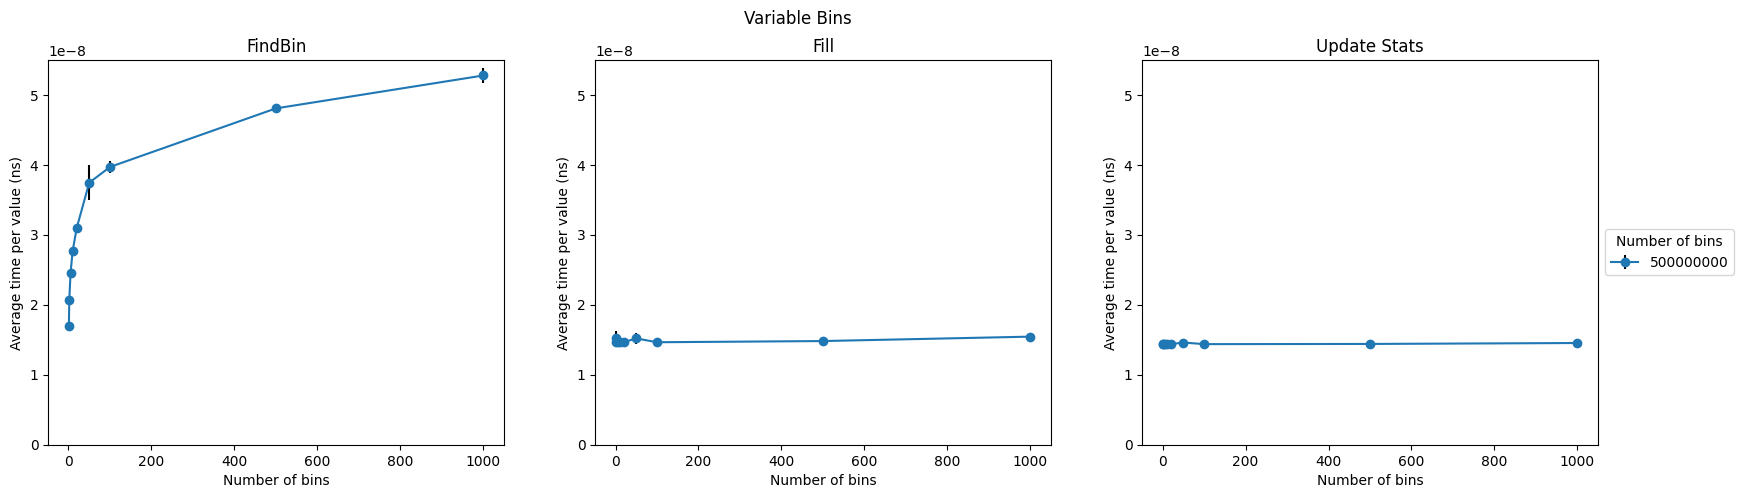

In [69]:
plt.figure(figsize=(20,5))
plt.suptitle("Variable Bins")

norm=1
ylim = [0*1e-8, 5.5*1e-8]
plt.subplot(131)
plot_perval_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(132)
plot_perval_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(133)
plot_perval_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [70]:
def convert_to_double_list(df, col):
    df[col] =  df[col].apply(lambda s: [np.float64(x) for x in s.split()])
    
filename = "nonbulk_1d_pervarbin.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_double_list(df_bm, "tfindbin")
convert_to_double_list(df_bm, "tfill")
convert_to_double(df_bm, "tstats")
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,"[0.0, 8.68143, 0.0]","[0.0, 7.492751, 0.0]",7.351574,500000000.0,uniform
1,0,CPU,2,1,"[0.0, 5.307118, 5.488702, 0.0]","[0.0, 3.86027, 3.858507, 0.0]",7.514040,500000000.0,uniform
2,0,CPU,5,1,"[0.0, 2.560204, 2.291943, 2.353472, 2.777817, ...","[0.0, 1.540131, 1.537355, 1.539111, 1.640972, ...",7.509003,500000000.0,uniform
3,0,CPU,10,1,"[0.0, 1.5087, 1.476285, 1.335727, 1.330733, 1....","[0.0, 0.753668, 0.752452, 0.750736, 0.752771, ...",7.362476,500000000.0,uniform
4,0,CPU,20,1,"[0.0, 0.813019, 0.798153, 0.786152, 0.78333, 0...","[0.0, 0.373925, 0.373674, 0.372761, 0.37377, 0...",7.267337,500000000.0,uniform
5,0,CPU,50,1,"[0.0, 0.378423, 0.363008, 0.362506, 0.369732, ...","[0.0, 0.186196, 0.1864, 0.186037, 0.18645, 0.1...",8.004499,500000000.0,uniform
6,0,CPU,100,1,"[0.0, 0.216131, 0.208753, 0.207718, 0.211024, ...","[0.0, 0.077682, 0.078071, 0.078216, 0.07779, 0...",7.602194,500000000.0,uniform


Plots the *average* time spent on finding a specific bin in an array with **100** bins for **0.5B** number of **doubles**. Total time averaged over **3 runs**

In [71]:
# w = 2400
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)
# c.Divide(2,1)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# g = ROOT.TGraph(100, np.arange(100, dtype=np.float64), gp_bm.agg(mean_list).loc["CPU", "uniform", 500000000, 100, 1]["tfindbin"][1:-1])
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")
# xaxis = g.GetXaxis()
# xaxis.SetTitle("Bin")
# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time (ns)")
# xaxis.SetRangeUser(0, 100)

# c.cd(1)
# g.Draw("ALP")

# title="Time to find bin in an array with 100 bins"
# g.SetTitle(title)

# l.Draw()
# c.Draw()

Investigate caching within Histogram Filling

## With Bulk API

### Fixed Bins

In [72]:
filename = "bulk_1d_fixedbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,1,1,9.366220,7.400088,7.680536,55.678274,500000000.0,uniform
1,0,CPU,2,1,9.033655,7.372012,7.210947,55.213912,500000000.0,uniform
2,0,CPU,5,1,9.041949,7.363795,7.208375,55.237908,500000000.0,uniform
3,0,CPU,10,1,9.020079,7.366081,7.205703,54.759593,500000000.0,uniform
4,0,CPU,20,1,9.026544,7.411118,7.209779,54.906053,500000000.0,uniform
5,0,CPU,50,1,9.017533,8.269012,7.266543,55.554767,500000000.0,uniform
6,0,CPU,100,1,9.047328,7.373376,7.209741,55.777299,500000000.0,uniform


In [73]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter  tfindbin     tfill  \
env distribution nvals       nbins bulksize                             
CPU uniform      500000000.0 1     1          1.0  9.127062  7.377659   
                                   2          1.0  8.993727  7.551290   
                                   4          1.0  8.978305  7.466884   
                                   8          1.0  8.982209  7.388648   
                                   16         1.0  8.996445  7.426486   
...                                           ...       ...       ...   
                             1000  16         1.0  8.989392  7.479603   
                                   32         1.0  8.996379  7.580759   
                                   64         1.0  8.996145  7.499995   
                                   128        1.0  9.001640  7.438422   
                                   256        1.0  9.027490  7.454698   

                                               tstats     ttotal  
env distribution nvals       nbins bulksize                       
CPU uniform      500000000.0 1     1         7.358422  57.045799  
                                   2         7.204478  49.809866  
                                   4         7.243781  44.789546  
                                   8         7.208031  40.427015  
                                   16        7.209041  39.260868  
...                                               ...        ...  
                             1000  16        7.205737  39.271879  
                                   32        7.206210  37.198711  
                                   64        7.300095  36.075708  
                                   128       7.214279  35.239546  
                                   256       7.206607  34.985127  

[81 rows x 5 columns]

In [74]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([5.e+08]),
 array([  1.,   2.,   4.,   8.,  16.,  32.,  64., 128., 256.]))

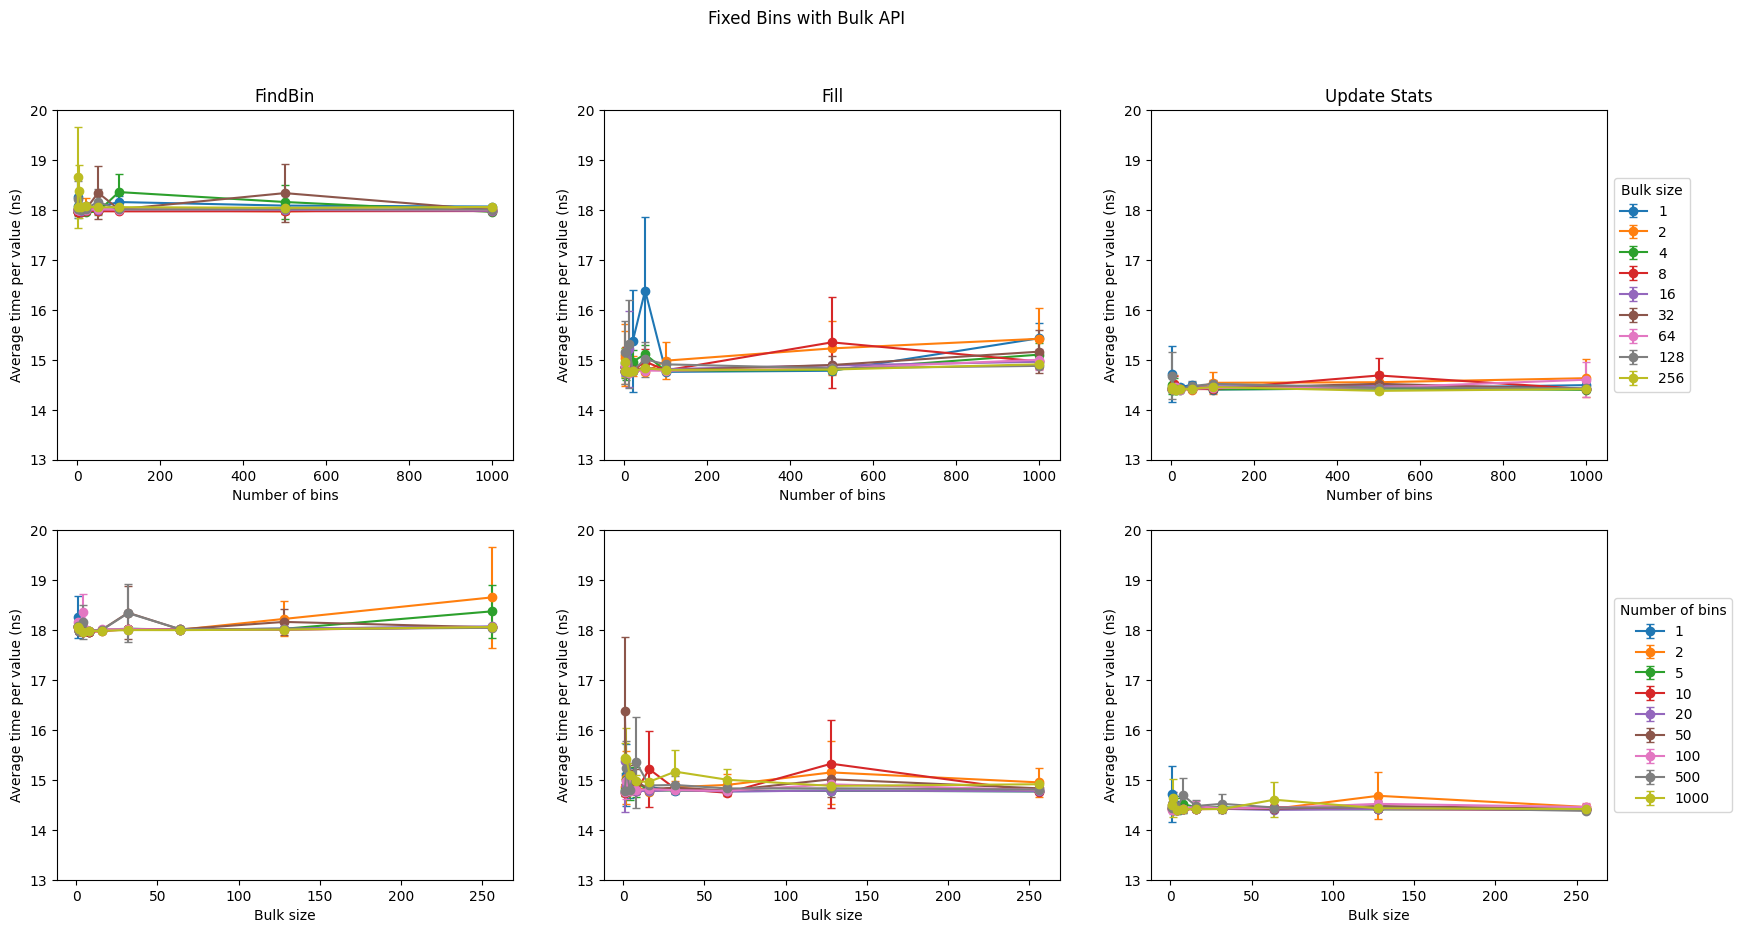

In [75]:
def plot_perbulk_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for bs in unique_bulksize:
        plt.errorbar(unique_nbins, gp_bm.mean().loc["CPU", "uniform", 5e8, :, bs][col]/norm, 
                     yerr=gp_bm.std().loc["CPU", "uniform", 5e8, :, bs][col]/norm, marker="o", 
                     capsize=3, label=f"{int(bs)}")
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_bulksize, gp_bm.mean().loc["CPU", "uniform", 5e8, nb, :][col]/norm, 
                     yerr=gp_bm.std().loc["CPU", "uniform", 5e8, nb, :][col]/norm, marker="o", 
                     capsize=3, label=f"{int(nb)}")
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins with Bulk API")

norm=unique_nvals*1e-9
xlim = []
ylim = [13, 20]
plt.subplot(231)
plot_perbulk_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(232)
plot_perbulk_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(233)
plot_perbulk_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)
plt.legend(title="Bulk size", loc='center left', bbox_to_anchor=(1, 0.5))

xlim = []
ylim = [13, 20]
plt.subplot(234)
plot_perbin_normalized("", "tfindbin", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(235)
plot_perbin_normalized("", "tfill", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(236)
plot_perbin_normalized("", "tstats", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Plot average total time. **Note that this timing includes overhead of timers for the measurements above**

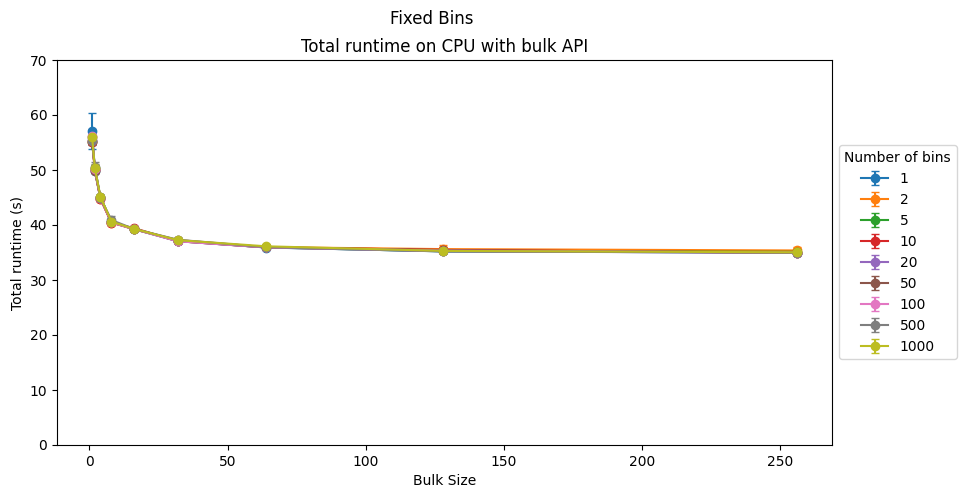

In [76]:
plt.figure(figsize=(10,5))
plt.suptitle("Fixed Bins")

norm=1
xlim = []
ylim = [0, 70]
plt.subplot(111)
plot_perbin_normalized("Total runtime on CPU with bulk API", "ttotal", "Bulk Size", "Total runtime (s)", xlim, ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

# Models

In [77]:
def f1_1(nbulks, bulksize, dim):
    T_d = 0
    T_u = 0
    T_RDF = 0 
    T_gb = 0
    T_mb = 0
    T_fb = 0
    T_usb = 0
    return T_d + T_u + T_RDF + np.sum([T_gb + T_mb + T_fb + T_usb for _ in range(nbulks)])

In [78]:
filename = "results.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})
df["param"] = df["name"].apply(lambda s: float(s.split("/")[1]))
df["func_name"] = df["name"].apply(lambda s: s.split("/")[0][3:])
df.head(10)

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,func_name
0,BM_UpdateStats/1/manual_time,0,0,BM_UpdateStats/1/manual_time,iteration,1,0,1,26524,0.025187,0.000247,ms,1.0,UpdateStats
1,BM_UpdateStats/2/manual_time,0,1,BM_UpdateStats/2/manual_time,iteration,1,0,1,10000,0.050257,0.000559,ms,2.0,UpdateStats
2,BM_UpdateStats/3/manual_time,0,2,BM_UpdateStats/3/manual_time,iteration,1,0,1,13869,0.052395,0.000568,ms,3.0,UpdateStats
3,BM_UpdateStats/4/manual_time,0,3,BM_UpdateStats/4/manual_time,iteration,1,0,1,7914,0.101599,0.000864,ms,4.0,UpdateStats
4,BM_UpdateStats/8/manual_time,0,4,BM_UpdateStats/8/manual_time,iteration,1,0,1,4071,0.170447,0.001003,ms,8.0,UpdateStats
5,BM_UpdateStats/16/manual_time,0,5,BM_UpdateStats/16/manual_time,iteration,1,0,1,1169,0.662787,0.001966,ms,16.0,UpdateStats
6,BM_UpdateStats/32/manual_time,0,6,BM_UpdateStats/32/manual_time,iteration,1,0,1,320,2.415594,0.004529,ms,32.0,UpdateStats
7,BM_UpdateStats/64/manual_time,0,7,BM_UpdateStats/64/manual_time,iteration,1,0,1,87,8.196690,0.012074,ms,64.0,UpdateStats
8,BM_UpdateStats/128/manual_time,0,8,BM_UpdateStats/128/manual_time,iteration,1,0,1,23,30.572348,0.036197,ms,128.0,UpdateStats
9,BM_BinarySearch/2/manual_time,1,0,BM_BinarySearch/2/manual_time,iteration,1,0,1,16029,0.042861,0.000118,ms,2.0,BinarySearch


## Update Stats Bulk

In [79]:
usb_df = df[df["func_name"] == "UpdateStats"]
usb_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,func_name
0,BM_UpdateStats/1/manual_time,0,0,BM_UpdateStats/1/manual_time,iteration,1,0,1,26524,0.025187,0.000247,ms,1.0,UpdateStats
1,BM_UpdateStats/2/manual_time,0,1,BM_UpdateStats/2/manual_time,iteration,1,0,1,10000,0.050257,0.000559,ms,2.0,UpdateStats
2,BM_UpdateStats/3/manual_time,0,2,BM_UpdateStats/3/manual_time,iteration,1,0,1,13869,0.052395,0.000568,ms,3.0,UpdateStats
3,BM_UpdateStats/4/manual_time,0,3,BM_UpdateStats/4/manual_time,iteration,1,0,1,7914,0.101599,0.000864,ms,4.0,UpdateStats
4,BM_UpdateStats/8/manual_time,0,4,BM_UpdateStats/8/manual_time,iteration,1,0,1,4071,0.170447,0.001003,ms,8.0,UpdateStats
5,BM_UpdateStats/16/manual_time,0,5,BM_UpdateStats/16/manual_time,iteration,1,0,1,1169,0.662787,0.001966,ms,16.0,UpdateStats
6,BM_UpdateStats/32/manual_time,0,6,BM_UpdateStats/32/manual_time,iteration,1,0,1,320,2.415594,0.004529,ms,32.0,UpdateStats
7,BM_UpdateStats/64/manual_time,0,7,BM_UpdateStats/64/manual_time,iteration,1,0,1,87,8.196690,0.012074,ms,64.0,UpdateStats
8,BM_UpdateStats/128/manual_time,0,8,BM_UpdateStats/128/manual_time,iteration,1,0,1,23,30.572348,0.036197,ms,128.0,UpdateStats


****************************************
Minimizer is Minuit / Migrad
Chi2                      =    0.0161218
NDf                       =            6
Edm                       =  2.57714e-20
NCalls                    =           59
p0                        =   -0.0184624   +/-   0.0253341   
p1                        =    0.0201972   +/-   0.00160842  
p2                        =   0.00344532   +/-   2.55192e-05 


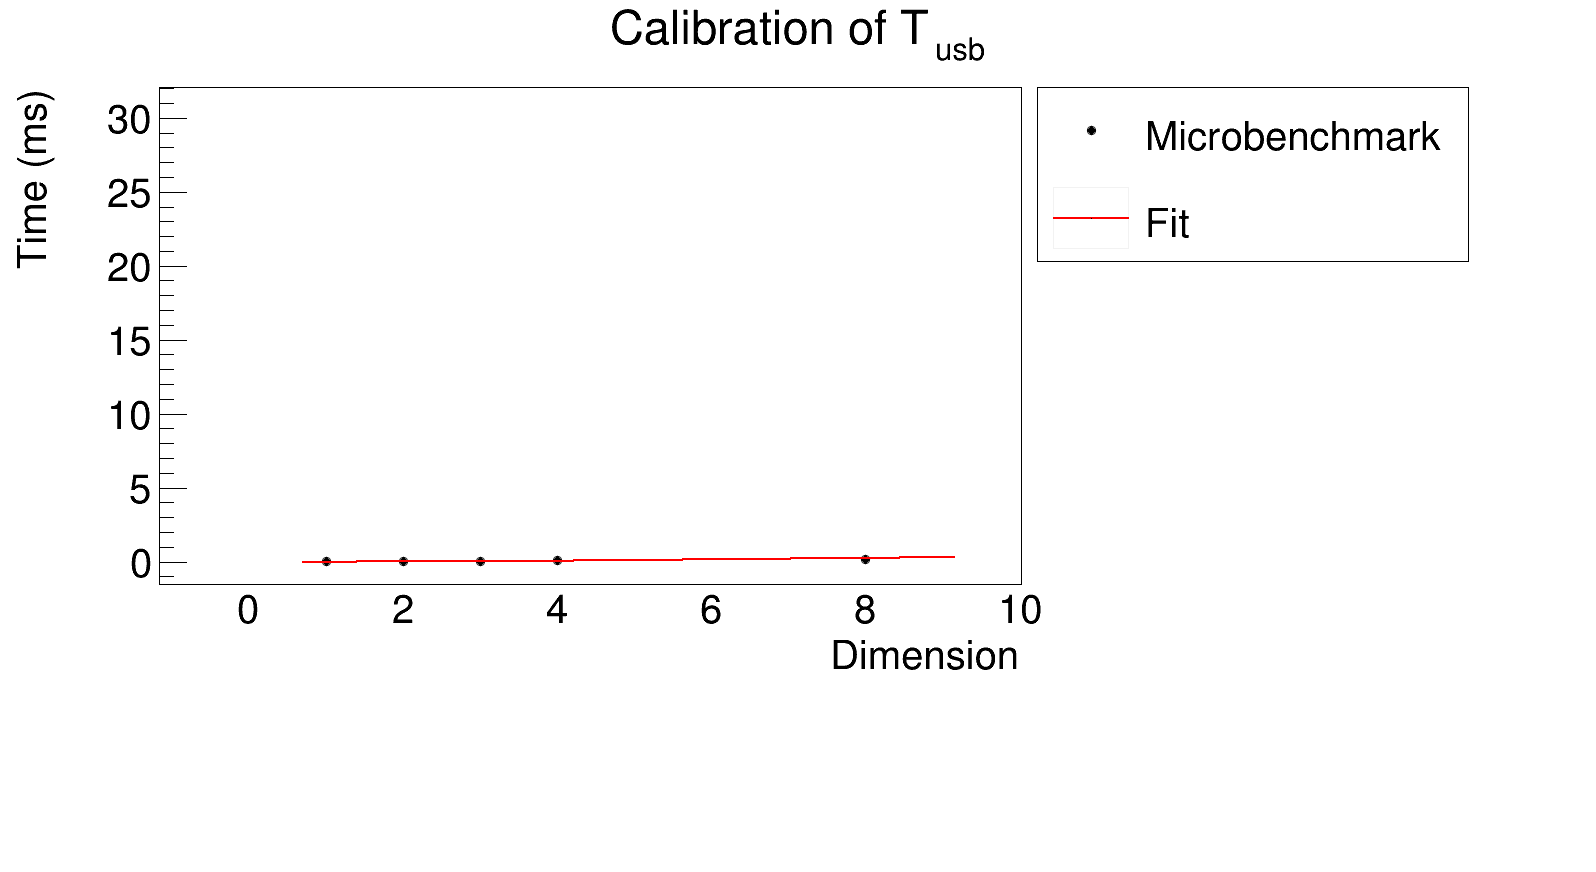

In [80]:
def f_usb(x, p):
    """
    Update Stats
    """
    return p[0] + x[0] * p[1] + x[0] * (x[0]-1) / 2 * p[2]
    # return T_alg1_3 + dim * T_alg1_5_6 + dim * (dim-1) / 2 * T_alg1_8

w = 1600
h = 900
c = ROOT.TCanvas("c1", "", w, h)
c.SetRightMargin(0.36)
c.SetBottomMargin(0.33)
c.Divide(1, 3);

l = ROOT.TLegend(0.65, 0.7, 0.92, 0.9)
l.SetTextSize(0.05)

title="Calibration of T_{usb}"
mg = ROOT.TMultiGraph("mg", title)

g = ROOT.TGraph(len(usb_df["param"]), usb_df["param"].values, usb_df["real_time"].values)
g.SetMarkerSize(1)
g.SetMarkerStyle(20)
mg.Add(g, "P")
l.AddEntry(g, "Microbenchmark", "p")

model_usb = ROOT.TF1("f_usb", f_usb, 1, 200, 3)
fit = g.Fit(model_usb, "S")
l.AddEntry(model_usb, f"Fit")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Dimension")
# xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.05)
xaxis.LabelsOption("vM")
xaxis.SetRangeUser(0, 10)

yaxis = mg.GetYaxis()
yaxis.SetTitle(f"Time ({usb_df['time_unit'][0]})")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# yaxis.SetRangeUser(0, 40)

mg.Draw("A")

l.Draw()
c.Draw()

## Binary Search

### sequential 

In [81]:
def search_distance(arr, x):
    count = len(arr)
    first = 0

    dist = 0
    while (count > 0):
      it = first
      step = int(count / 2);
      it += step;
    
      if (arr[it] < x):
         first = it + 1
         count -= step + 1;
      else:
         count = step;
      dist += 1
    return dist

In [82]:
filename = "binsearch.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})
df["param"] = df["name"].apply(lambda s: float(s.split("/")[1]))
df["distance"] = df["param"].apply(lambda s: search_distance(np.linspace(0,1,1000), s))
df["func_name"] = df["name"].apply(lambda s: s.split("/")[0][3:])
bs_df = df[df["func_name"] == "BinarySearch"]
bs_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,distance,func_name
0,BM_BinarySearch/1/manual_time,0,0,BM_BinarySearch/1/manual_time,iteration,1,0,1,156,4.551525,4.546999,ms,1.0,10,BinarySearch
1,BM_BinarySearch/2/manual_time,0,1,BM_BinarySearch/2/manual_time,iteration,1,0,1,139,5.054828,5.054439,ms,2.0,9,BinarySearch
2,BM_BinarySearch/3/manual_time,0,2,BM_BinarySearch/3/manual_time,iteration,1,0,1,162,4.251436,4.246140,ms,3.0,9,BinarySearch
3,BM_BinarySearch/4/manual_time,0,3,BM_BinarySearch/4/manual_time,iteration,1,0,1,133,5.065160,5.059299,ms,4.0,9,BinarySearch
4,BM_BinarySearch/5/manual_time,0,4,BM_BinarySearch/5/manual_time,iteration,1,0,1,157,4.432735,4.422897,ms,5.0,9,BinarySearch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BM_BinarySearch/96/manual_time,0,95,BM_BinarySearch/96/manual_time,iteration,1,0,1,149,4.628474,4.628069,ms,96.0,9,BinarySearch
96,BM_BinarySearch/97/manual_time,0,96,BM_BinarySearch/97/manual_time,iteration,1,0,1,171,4.062870,4.062653,ms,97.0,9,BinarySearch
97,BM_BinarySearch/98/manual_time,0,97,BM_BinarySearch/98/manual_time,iteration,1,0,1,146,4.853625,4.853160,ms,98.0,9,BinarySearch
98,BM_BinarySearch/99/manual_time,0,98,BM_BinarySearch/99/manual_time,iteration,1,0,1,147,4.781845,4.781564,ms,99.0,9,BinarySearch


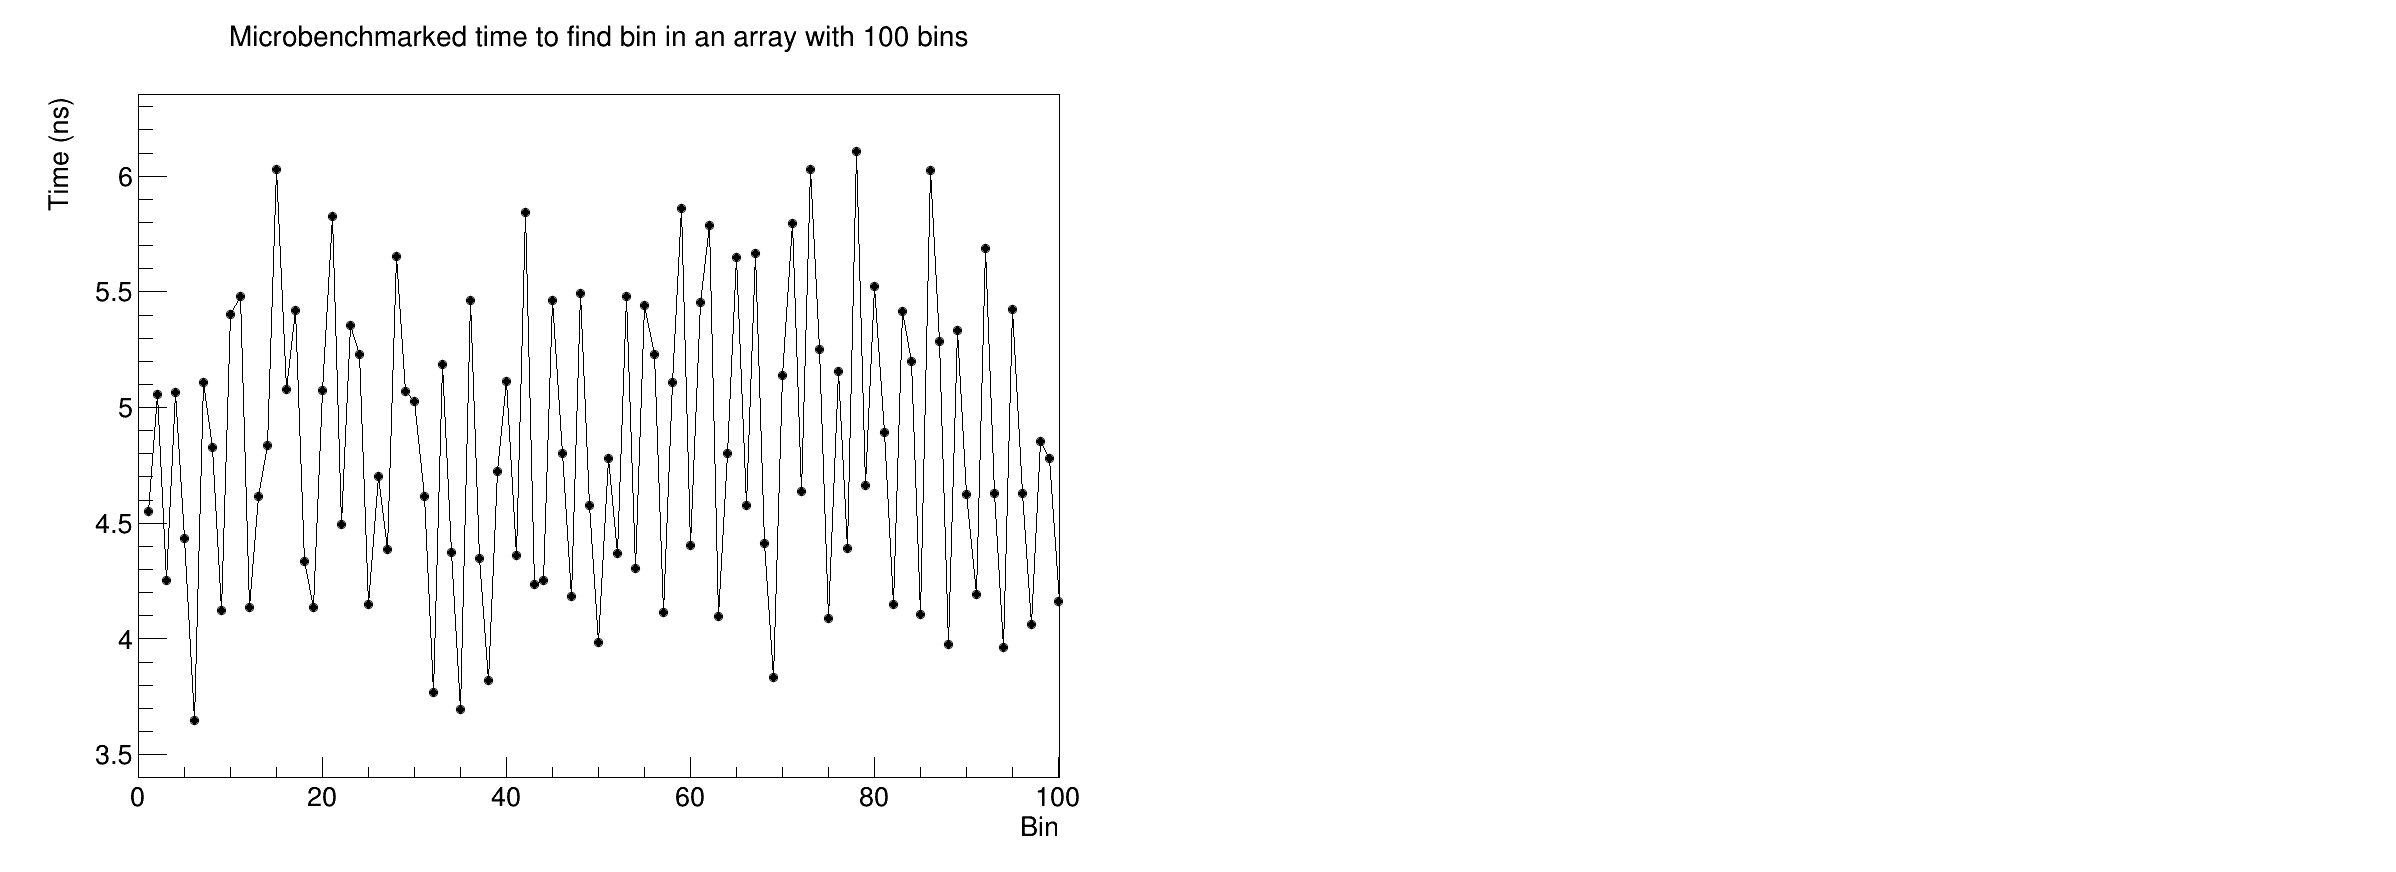

In [83]:
w = 2400
h = 900
c = ROOT.TCanvas("c1", title, w, h)
c.SetRightMargin(0.32)
c.SetBottomMargin(0.33)
c.Divide(2,1)

l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
l.SetTextSize(0.05)

g = ROOT.TGraph(len(bs_df["param"]), bs_df["param"].values, bs_df["real_time"].values)
g.SetMarkerSize(1)
g.SetMarkerStyle(8)
l.AddEntry(g, "Microbenchmark", "p")
xaxis = g.GetXaxis()
xaxis.SetTitle("Bin")
yaxis = g.GetYaxis()
yaxis.SetTitle(f"Time (ns)")
xaxis.SetRangeUser(0, 100)

c.cd(1)
g.Draw("ALP")

title="Microbenchmarked time to find bin in an array with 100 bins"
g.SetTitle(title)

# l.Draw()
c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

In [84]:
bs_df["real_time"].mean() * 500000000 / 1e9, gp_bm.mean().loc["CPU", "uniform", 500000000, 100, 1]["tfindbin"]

(2.4166954895719797, 9.076766999999998)

### Uniform random

In [85]:
bs_df = df[df["func_name"] == "BinarySearch"]
bs_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,distance,func_name
0,BM_BinarySearch/1/manual_time,0,0,BM_BinarySearch/1/manual_time,iteration,1,0,1,156,4.551525,4.546999,ms,1.0,10,BinarySearch
1,BM_BinarySearch/2/manual_time,0,1,BM_BinarySearch/2/manual_time,iteration,1,0,1,139,5.054828,5.054439,ms,2.0,9,BinarySearch
2,BM_BinarySearch/3/manual_time,0,2,BM_BinarySearch/3/manual_time,iteration,1,0,1,162,4.251436,4.246140,ms,3.0,9,BinarySearch
3,BM_BinarySearch/4/manual_time,0,3,BM_BinarySearch/4/manual_time,iteration,1,0,1,133,5.065160,5.059299,ms,4.0,9,BinarySearch
4,BM_BinarySearch/5/manual_time,0,4,BM_BinarySearch/5/manual_time,iteration,1,0,1,157,4.432735,4.422897,ms,5.0,9,BinarySearch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BM_BinarySearch/96/manual_time,0,95,BM_BinarySearch/96/manual_time,iteration,1,0,1,149,4.628474,4.628069,ms,96.0,9,BinarySearch
96,BM_BinarySearch/97/manual_time,0,96,BM_BinarySearch/97/manual_time,iteration,1,0,1,171,4.062870,4.062653,ms,97.0,9,BinarySearch
97,BM_BinarySearch/98/manual_time,0,97,BM_BinarySearch/98/manual_time,iteration,1,0,1,146,4.853625,4.853160,ms,98.0,9,BinarySearch
98,BM_BinarySearch/99/manual_time,0,98,BM_BinarySearch/99/manual_time,iteration,1,0,1,147,4.781845,4.781564,ms,99.0,9,BinarySearch


****************************************
Minimizer is Minuit / Migrad
Chi2                      =       38.745
NDf                       =           98
Edm                       =  3.82603e-21
NCalls                    =           33
p0                        =    0.0356546   +/-   0.0471987   
p1                        =      4.64629   +/-   0.255539    
****************************************
Minimizer is Minuit / Migrad
Chi2                      =       38.747
NDf                       =           97
Edm                       =  5.68916e-07
NCalls                    =          203
p0                        =      2.24217   +/-   0.793684    
p1                        =    0.0213502   +/-   0.0277391   
p2                        =       2.4097   +/-   0.800222    


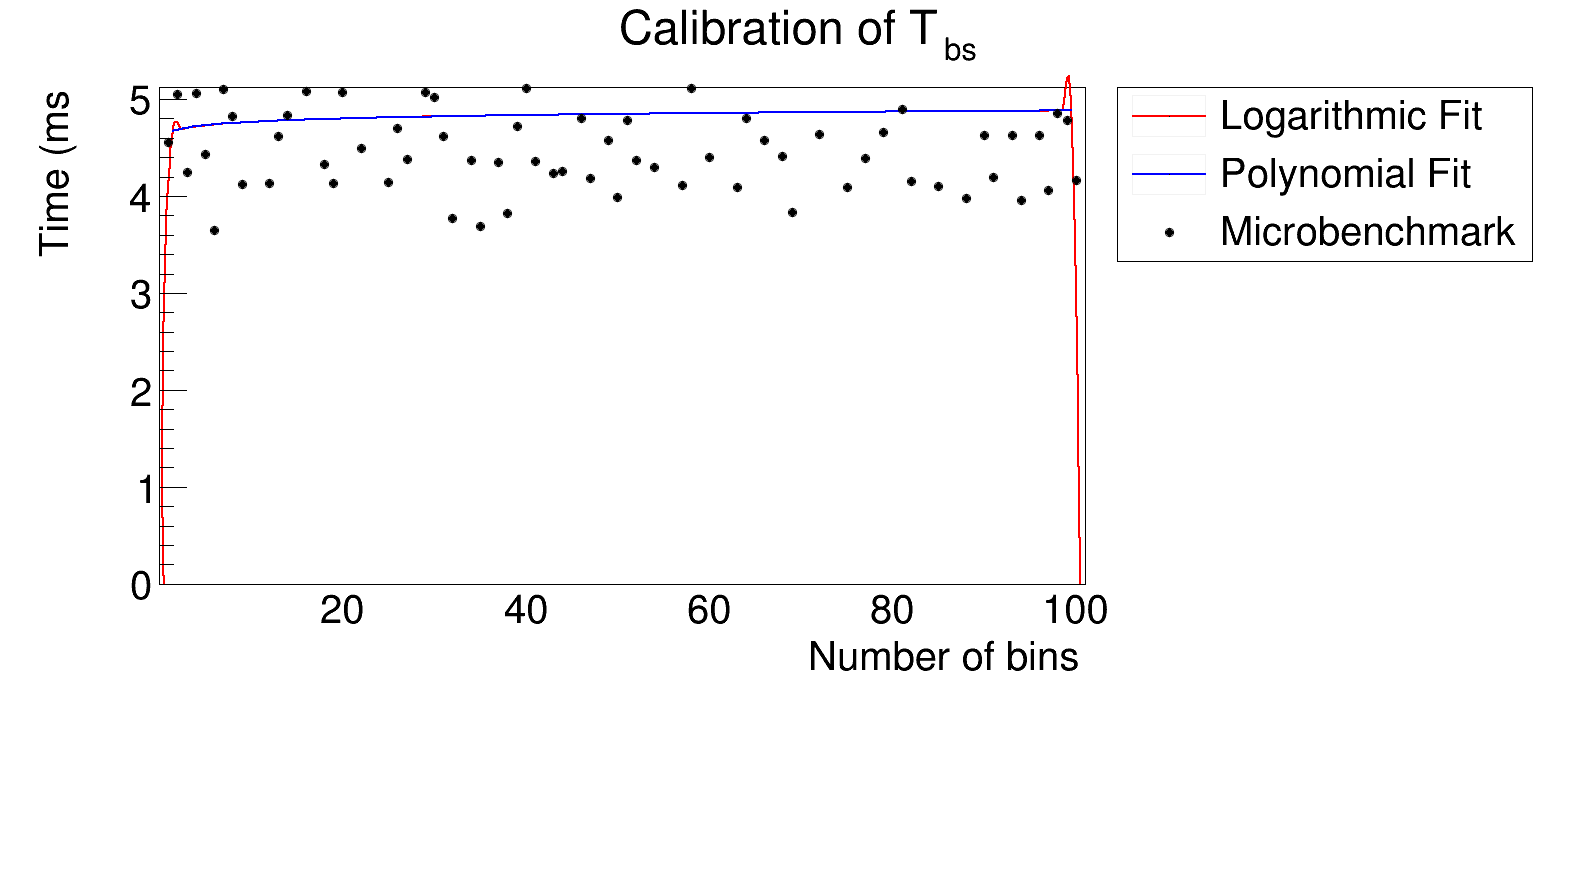

In [86]:
%jsroot off
def f_bs_log(x, p):
    """
    Binary Search
    """
    return p[0] * np.log2(x[0]) +  p[1]

def f_bs_polynomial(x, p):
    """
    Binary Search
    """
    return p[0] * x[0]**(p[1]) + p[2]

title="Model Update Stats Bulk"
w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
c.SetRightMargin(0.32)
c.SetBottomMargin(0.33)

l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
l.SetTextSize(0.05)

model_bs_log = ROOT.TF1("f_bs_log", f_bs_log, bs_df["param"].min(), bs_df["param"].max(), 2)
fit_log = g.Fit(model_bs_log, "", "", 10e-3, 40e4)
l.AddEntry(model_bs_log, "Logarithmic Fit")

model_bs_poly = ROOT.TF1("f_bs_polynomial", f_bs_polynomial, bs_df["param"].min(), bs_df["param"].max(), 3)
fit_poly = g.Fit(model_bs_poly, "", "", 10e-3, 40e4)
l.AddEntry(model_bs_poly, "Polynomial Fit")
model_bs_poly.SetLineColor(ROOT.kBlue)

g = ROOT.TGraph(len(bs_df["param"]), bs_df["param"].values, bs_df["real_time"].values)
g.SetMarkerSize(1)
g.SetMarkerStyle(8)
l.AddEntry(g, "Microbenchmark", "p")

xaxis = model_bs_log.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.05)
xaxis.LabelsOption("vM")
xaxis.SetRangeUser(0, 5*10e3)

yaxis = model_bs_log.GetYaxis()
yaxis.SetTitle(f"Time ({list(bs_df['time_unit'])[0]}")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# yaxis.SetRangeUser(0, 0.4)


model_bs_log.Draw("C")
model_bs_poly.Draw("CSAME")
g.Draw("PSAME")

title="Calibration of T_{bs}"
model_bs_log.SetTitle(title)

l.Draw()
c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

## Histogram Fill

In [87]:
fb_df = df[df["func_name"] == "Histogram"]
fb_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,distance,func_name


In [88]:
def f_fb(fixed, bulksize):
    if fixed:
        return bulksize * (T_alg1_16 + T_alg1_23)
    return bulksize * (T_alg1_18 + T_alg1_23)

w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
c.SetRightMargin(0.32)
c.SetBottomMargin(0.33)

l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
l.SetTextSize(0.05)

# model_fb = ROOT.TF1("f_bs", f_bs, fb_df["param"].min(), fb_df["param"].max(), 3)
# fit = g.Fit(model_fb, "", "", 10e-3, 40e4)
# l.AddEntry(model_fb, "Fit")

g = ROOT.TGraph(len(fb_df["param"]), fb_df["param"].values, fb_df["real_time"].values)
g.SetMarkerSize(1)
g.SetMarkerStyle(8)
l.AddEntry(g, "Microbenchmark", "p")

xaxis = g.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.05)
xaxis.LabelsOption("vM")
xaxis.SetRangeUser(0, 5*10e3)

yaxis = g.GetYaxis()
yaxis.SetTitle(f"Time ({list(bs_df['time_unit'])[0]}")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# yaxis.SetRangeUser(0, 0.4)


# model_bs.Draw("C")
g.Draw("APSAME")

# title="Calibration of T_{bs}"
# model_bs.SetTitle(title)

l.Draw()
c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

TypeError: none of the 12 overloaded methods succeeded. Full details:
  TGraph::TGraph(const TGraph& gr) =>
    TypeError: takes at most 1 arguments (3 given)
  TGraph::TGraph(const TVectorT<float>& vx, const TVectorT<float>& vy) =>
    TypeError: takes at most 2 arguments (3 given)
  TGraph::TGraph(const TVectorT<double>& vx, const TVectorT<double>& vy) =>
    TypeError: takes at most 2 arguments (3 given)
  TGraph::TGraph(const TH1* h) =>
    TypeError: takes at most 1 arguments (3 given)
  TGraph::TGraph(const TF1* f, const char* option = "") =>
    TypeError: takes at most 2 arguments (3 given)
  TGraph::TGraph() =>
    TypeError: takes at most 0 arguments (3 given)
  TGraph::TGraph(int n) =>
    TypeError: takes at most 1 arguments (3 given)
  TGraph::TGraph(const char* filename, const char* format = "%lg %lg", const char* option = "") =>
    TypeError: could not convert argument 1 (bad argument type for built-in operation)
  TGraph::TGraph(int n, const double* y, double start = 0., double step = 1.) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraph::TGraph(int n, const int* x, const int* y) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraph::TGraph(int n, const float* x, const float* y) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraph::TGraph(int n, const double* x, const double* y) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)